# Advanced Lane Finding

### 1- Camera Calebraion and Distortion Correction : 

In [130]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [131]:

def calibrate_distort_cam(images, test_image_name='test', corners_w=9, corners_h=6):
    """
    @param: images , array of images paths ['folder//image_name.jpg',..]
    """
    # prepare object points, 
    # 6*8 length arrays, length=3 each , like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((corners_w*corners_h,3), np.float32)
    objp[:,:2] = np.mgrid[0:corners_w, 0:corners_h].T.reshape(-1,2)#create grid of 2 arrays, then reshape to 6*9, then replace values in objp
    """output :
    [[ 0.  0.  0.]
     [ 1.  0.  0.]
     ...
     [ 7.  5.  0.]
     [ 8.  5.  0.]]
    """
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)#read image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#convert to gray
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('chess board', fontsize=20)
    # Draw and display the corners of an image
    cv2.drawChessboardCorners(img, (9,6), corners, ret)
    
    ax2.imshow(img)
    ax2.set_title('chess board inner corners', fontsize=20)
    #calibration 
    test_img = cv2.imread('camera_cal/'+test_image_name+'.jpg')
    img_size = (test_img.shape[1], test_img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        
    # Test undistortion on an image
    undistorted_img = cv2.undistort(test_img, mtx, dist, None, mtx)
    #display
    ax3.imshow(test_img)
    ax3.set_title('Original Image', fontsize=20)
    ax4.imshow(undistorted_img)
    ax4.set_title('Undistorted Image', fontsize=20)
    
    return mtx, dist


In [132]:
import pickle
def save_calibration(mtx, dist, folder='camera_cal'):
    # Save the camera calibration result for later use
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( folder+"/wide_dist_pickle.p", "wb" ) )

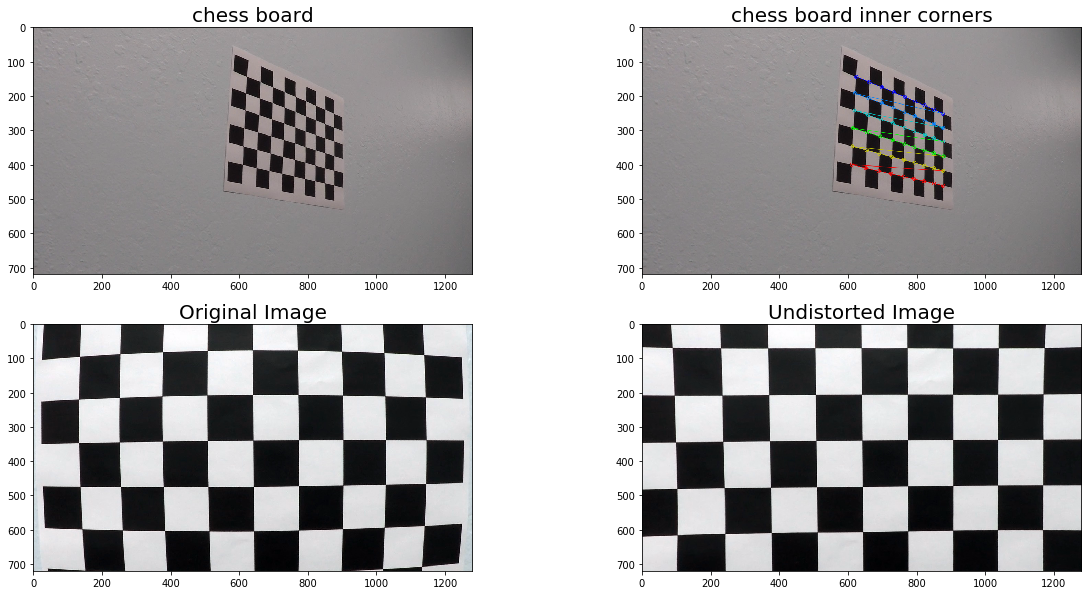

In [133]:
# Make a list of calibration images urls
images = glob.glob('camera_cal/calibration*.jpg')
mtx, dist = calibrate_distort_cam(images)
    
save_calibration(mtx, dist)



### 2-  Color/Gradient Threshold

In [134]:
import matplotlib.image as mpimg
def abs_sobel_thresh(s_channel, orient='x', sobel_kernel=3, s_thresh=(0, 255)):
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'y':
        sobel = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in y
    else:
        sobel = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    
    abs_sobel = np.absolute(sobel) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Threshold x gradient
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= s_thresh[0]) & (scaled_sobel <= s_thresh[1])] = 1
    
    return sobel_binary

In [135]:
def s_hls_thresh(s_channel, s_thresh=(0, 255)):
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Return the result
    return s_binary

In [136]:
def pipeline_gradiant_thresh(undistimg, s_thresh=(200, 230),sobel_thresh=(20, 100), do_plot=False):
    img = np.copy(undistimg)
    #img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    # equalize the histogram of the Y channel
    #img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    #img_yuv[:,:,2] = cv2.equalizeHist(img_yuv[:,:,2])
    # convert the YUV image back to RGB format
    #img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    
    # Choose a Sobel kernel size
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float)
    """
    xyz = cv2.cvtColor(img, cv2.COLOR_RGB2XYZ).astype(np.float)
    
    img_from_z = np.zeros((img.shape[0], img.shape[1], 3), dtype = img.dtype) 
    print(img_from_z.shape,img_from_z[:,:,0].shape,xyz.shape,xyz[:,:,0].shape,xyz[:,:,1].shape,xyz[:,:2].shape)
    img_from_z[:,:,0] = xyz[:,:,0]
    
    lab_from_xyz = cv2.cvtColor(img_from_z, cv2.COLOR_RGB2LAB).astype(np.float)
    """
    #s_channel = hls[:,:,2]
    s_channel = hls[:,:,2]
    lab_l_channel = lab[:,:,0]
    lab_b_channel = lab[:,:,2]
    #hls_l_channel = hls[:,:,1]
    # Apply each of the thresholding functions
    #sobel_x_binary_HLS = abs_sobel_thresh(hls_l_channel, orient='x', sobel_kernel=17, s_thresh=sobel_thresh)
    
    # Apply each of the thresholding functions
    print("sobel_thresh=",sobel_thresh,", sobel_kernel=",9,"then",1)
    sobel_x_binary_L = abs_sobel_thresh(lab_l_channel, orient='x', sobel_kernel=9, s_thresh=sobel_thresh)
    sobel_x_binary_B = abs_sobel_thresh(lab_b_channel, orient='x', sobel_kernel=1, s_thresh=sobel_thresh)
    #sobel_x_binary = np.dstack(( np.zeros_like(sobel_x_binary_L), sobel_x_binary_L, sobel_x_binary_B))
    sobel_x_binary = np.zeros_like(sobel_x_binary_L)
    sobel_x_binary[(sobel_x_binary_L == 1) | (sobel_x_binary_B == 1)] = 1
    
    #sobel_x_binary = np.zeros_like(sobel_x_binary_HLS)
    #sobel_x_binary[(sobel_x_binary_HLS == 1) | (sobel_x_binary_LB == 1)] = 1
    
    s_binary = s_hls_thresh(s_channel, s_thresh=s_thresh)
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(sobel_x_binary), sobel_x_binary, s_binary))
    color_binary = np.dstack(( np.zeros_like(sobel_x_binary), sobel_x_binary, s_binary))
    
    if do_plot:
        #"""
        f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(13, 6))
        f.tight_layout()
        f.suptitle("Sobel X with L channel & S channel thresholded :", fontsize=30)

        ax1.imshow(lab[:,:,0])
        ax1.set_title('L', fontsize=20)

        ax2.imshow(lab[:,:,1])
        ax2.set_title('A', fontsize=20)

        ax3.imshow(lab[:,:,2])
        ax3.set_title('B', fontsize=20)
        plt.show()
        
        f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(13, 6))
        f.tight_layout()
        f.suptitle("Sobel X with L channel & S channel thresholded :", fontsize=30)

        ax1.imshow(hls[:,:,0])
        ax1.set_title('H', fontsize=20)

        ax2.imshow(hls[:,:,1])
        ax2.set_title('L', fontsize=20)

        ax3.imshow(hls[:,:,2])
        ax3.set_title('S', fontsize=20)
        plt.show()
        #"""
        f,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(13, 6))
        f.tight_layout()
        f.suptitle("Sobel X : L channel & B channel  Mixed", fontsize=30)

        ax1.imshow(sobel_x_binary_L, cmap='gray')
        ax1.set_title('L', fontsize=20)

        ax2.imshow(sobel_x_binary_B, cmap='gray')
        ax2.set_title('+ B', fontsize=20)

        ax3.imshow(sobel_x_binary, cmap='gray')
        ax3.set_title('+ H of HLS', fontsize=20)
        plt.show()

        f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(24, 13))
        f.tight_layout()
        f.suptitle("Sobel X with L channel & S channel thresholded :", fontsize=30)

        ax1.imshow(img)
        ax1.set_title('Original image', fontsize=20)

        ax4.imshow(img)
        ax4.set_title('Original image', fontsize=20)

        ax2.imshow(sobel_x_binary_L)
        ax2.set_title('L channel of image HLS', fontsize=20)

        ax5.imshow(s_channel)
        ax5.set_title('S channel of image HLS', fontsize=20)

        ax3.imshow(sobel_x_binary, cmap='gray')
        ax3.set_title('Binary Sobel X', fontsize=20)

        ax6.imshow(s_binary, cmap='gray')
        ax6.set_title('S Channel Binary', fontsize=20)
    return color_binary, sobel_x_binary , s_binary 

In [137]:
def compine_sobel_schannel(sobelx_binary, schannel_binary, result, do_plot=False):
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(schannel_binary == 1) | (sobelx_binary == 1)] = 1
    
    if do_plot:
        f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
        f.tight_layout()
        f.suptitle("Combined Results :", fontsize=30)
        ax1.imshow(result)
        ax1.set_title('Pipeline Result', fontsize=20)

        ax2.imshow(combined_binary, cmap='gray')
        ax2.set_title('Combined Binary', fontsize=20)
    return combined_binary

sobel_thresh= (20, 100) , sobel_kernel= 9 then 1


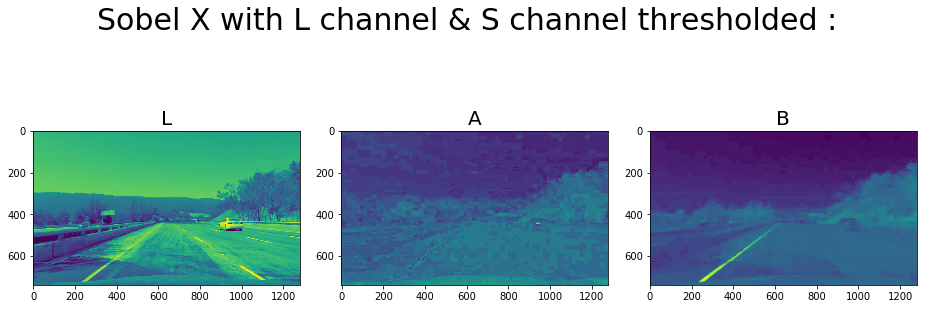

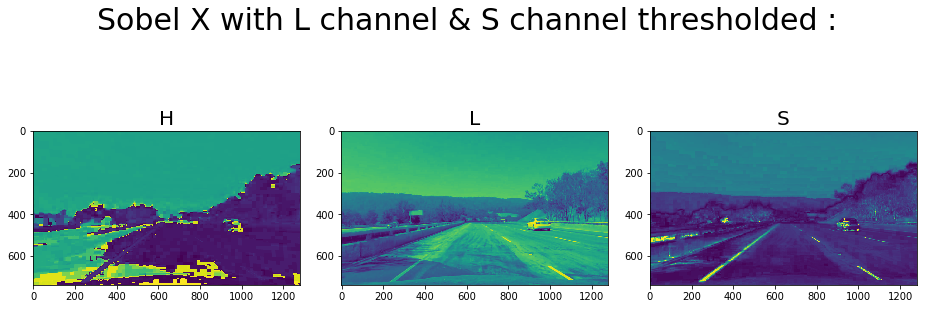

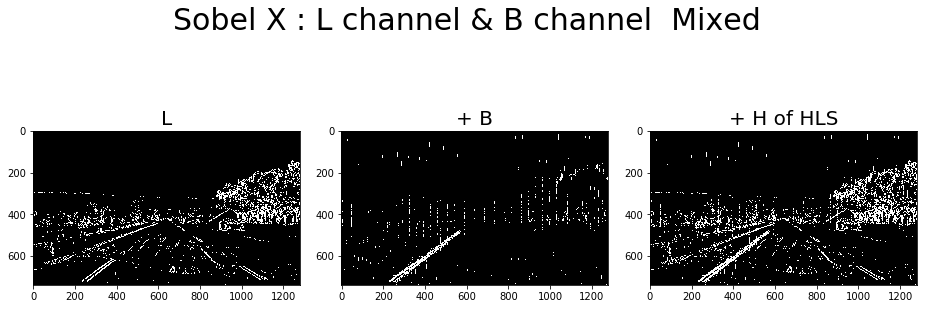

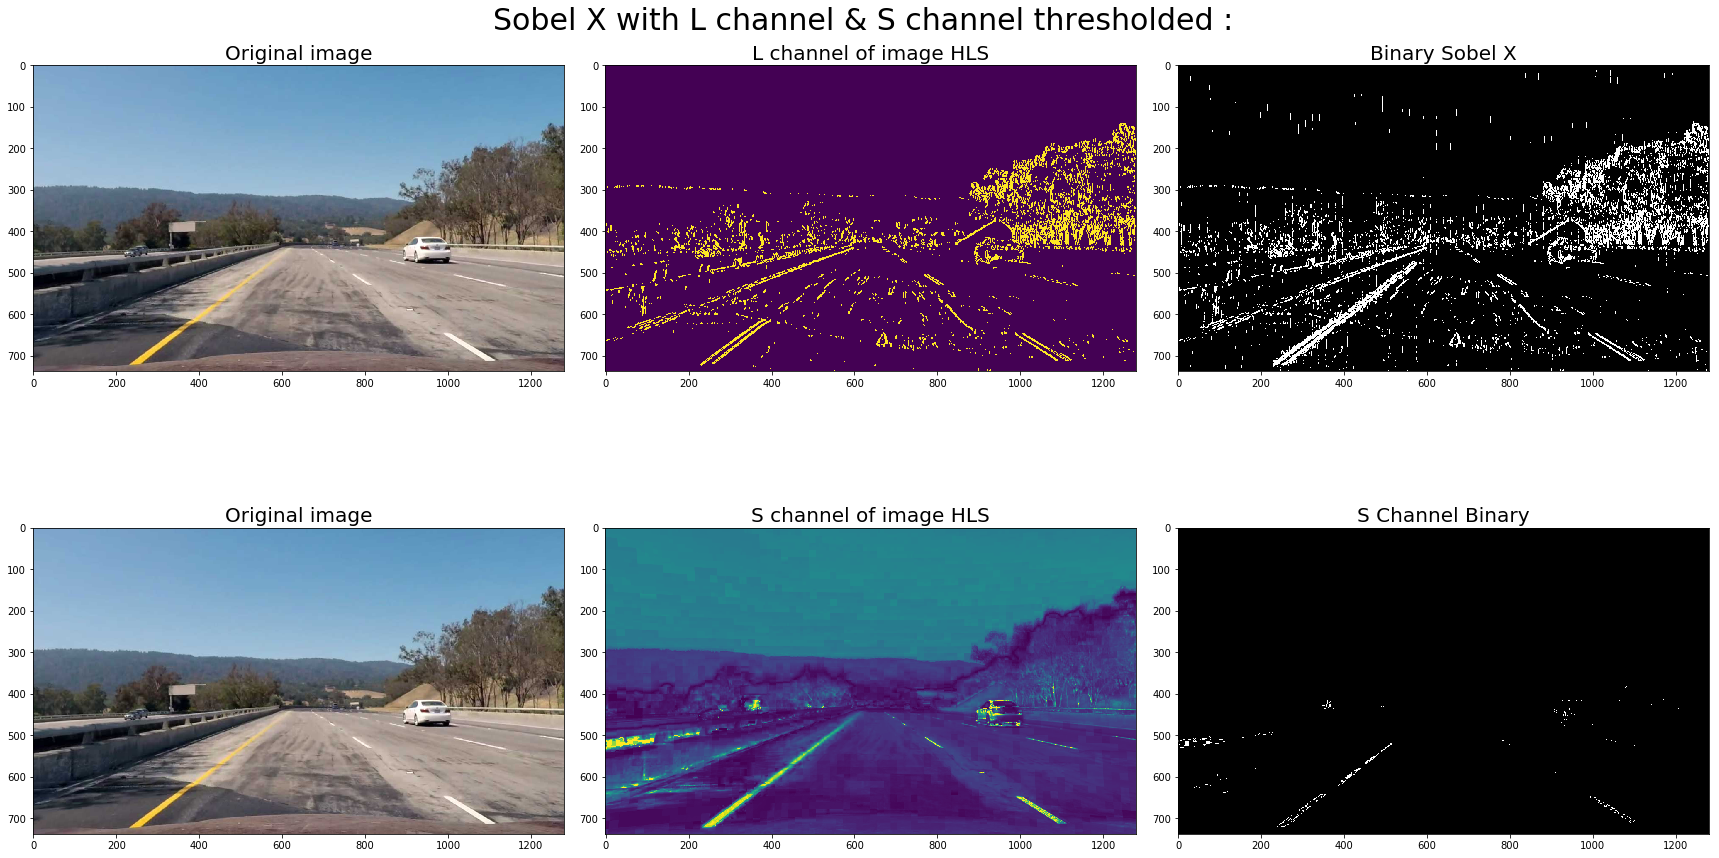

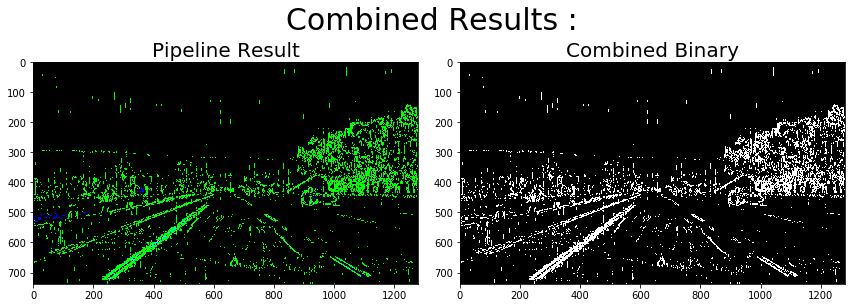

In [138]:
image = cv2.imread('test_images/anas0.jpg')#test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist_img = cv2.undistort(image, mtx, dist, None, mtx)
                                                                                    #   170,200
result, sobelx_binary, schannel_binary = pipeline_gradiant_thresh(undist_img, do_plot=True)

#TODO: add to pipeline functions 
combined_binary = compine_sobel_schannel(sobelx_binary, schannel_binary, result, do_plot=True)

### 3- Perspective transform

##### 3a - adjust prespective on an image that has a straight lane line 

warped_img (738, 1280)
warped_img uint8


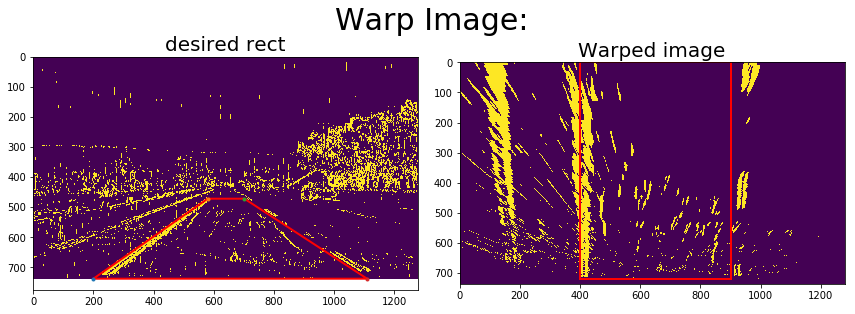

In [ ]:
import matplotlib.patches as patches

def warp(image, do_plot=False):
   
    img_size = (image.shape[1], image.shape[0])
    horizon = int(img_size[1]*.64)#0.62
    
    src_vertices = np.float32(
        [[200,     img_size[1]],#LB
        [580, horizon],         #LT
        [702, horizon], 
        [1110,     img_size[1]]])
        #[[200,     img_size[1]],#LB
        #[599, horizon],         #LT
        #[678, horizon], 
        #[1110,     img_size[1]]])
    
    dst_vertices = np.float32(
        [[400, 720],
        [400, 0], 
        [900, 0], 
        [900, 720]])
        
    #warp matrix
    M = cv2.getPerspectiveTransform(src_vertices, dst_vertices)
    #unwarp matrix
    Minv = cv2.getPerspectiveTransform(dst_vertices, src_vertices)
    #do warp 
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    if do_plot:
        f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
        f.tight_layout()
        f.suptitle("Warp Image:", fontsize=30)
        ax1.imshow(image)
        ax1.plot(src_vertices[0][0],src_vertices[0][1],'.')
        ax1.plot(src_vertices[1][0],src_vertices[1][1],'.')
        ax1.plot(src_vertices[2][0],src_vertices[2][1],'.')
        ax1.plot(src_vertices[3][0],src_vertices[3][1],'.')
        ax1.add_patch(patches.Polygon(src_vertices, linewidth=2, edgecolor='r', facecolor='none'))
        ax1.set_title('desired rect', fontsize=20)
        ax2.imshow(warped)
        ax2.add_patch(patches.Polygon(dst_vertices, linewidth=2, edgecolor='r', facecolor='none'))
        #ax2.add_patch(patches.Rectangle((290,0),750,720,linewidth=2,edgecolor='r',facecolor='none'))
        ax2.set_title('Warped image', fontsize=20)

    return warped, Minv

warped_img , warped_img_Minv= warp(combined_binary , do_plot=True)
print("warped_img",warped_img.shape)
print("warped_img",warped_img.dtype)

###### 3b - test same process on curved line

In [ ]:
curved_image2 = cv2.imread('test_images/test2.jpg')
curved_image2 = cv2.cvtColor(curved_image2, cv2.COLOR_BGR2RGB)
undist_curved_image2 = cv2.undistort(curved_image2, mtx, dist, None, mtx)

curved_result2, curved_sobelx_binary2, curved_schannel_binary2 = pipeline_gradiant_thresh(undist_curved_image2, do_plot=False)

#TODO: add to pipeline functions 
curved_combined_binary2 = compine_sobel_schannel(curved_sobelx_binary2, curved_schannel_binary2,curved_result2,do_plot=False)

curved_warped_img2, curved_warped_img2_Minv = warp(curved_combined_binary2 , do_plot=True)

sobel_thresh= (20, 100) , sobel_kernel= 9 then 1


another test, the other way

In [ ]:
curved_image3 = cv2.imread('test_images/test3.jpg')
curved_image3 = cv2.cvtColor(curved_image3, cv2.COLOR_BGR2RGB)
undist_curved_image3 = cv2.undistort(curved_image3, mtx, dist, None, mtx)
curved_result3, curved_sobelx_binary3, curved_schannel_binary3 = pipeline_gradiant_thresh(undist_curved_image3, do_plot=False)

#TODO: add to pipeline functions 
curved_combined_binary3 = compine_sobel_schannel(curved_sobelx_binary3, curved_schannel_binary3,curved_result3,do_plot=False)

curved_warped_img3, curved_warped_img3_Minv = warp(curved_combined_binary3 , do_plot=True)

bright lighting conditions

In [ ]:
curved_image1 = cv2.imread('test_images/test1.jpg')
curved_image1 = cv2.cvtColor(curved_image1, cv2.COLOR_BGR2RGB)
undist_curved_image1 = cv2.undistort(curved_image1, mtx, dist, None, mtx)
curved_result1, curved_sobelx_binary1, curved_schannel_binary1 = pipeline_gradiant_thresh(undist_curved_image1, do_plot=True)

#TODO: add to pipeline functions 
curved_combined_binary1 = compine_sobel_schannel(curved_sobelx_binary1, curved_schannel_binary1, curved_result1, do_plot=True)

curved_warped_img1, curved_warped_img1_Minv = warp(curved_combined_binary1 , do_plot=True)

another crazy lighting conditions

In [ ]:
curved_image4 = cv2.imread('test_images/test4.jpg')
curved_image4 = cv2.cvtColor(curved_image4, cv2.COLOR_BGR2RGB)
undist_curved_image4 = cv2.undistort(curved_image4, mtx, dist, None, mtx)
curved_result4, curved_sobelx_binary4, curved_schannel_binary4 = pipeline_gradiant_thresh(undist_curved_image4, do_plot=True)

#TODO: add to pipeline functions 
curved_combined_binary4 = compine_sobel_schannel(curved_sobelx_binary4, curved_schannel_binary4, curved_result4, do_plot=False)

curved_warped_img4, curved_warped_img4_Minv = warp(curved_combined_binary4 , do_plot=True)

### 4- find the lane in the bird-eye image

dedecting lane for :
- warped_img : which is straight line
- curved_warped_img2 : clear curved to left
- curved_warped_img3 : clear curved to right
- curved_warped_img1 : confusing curved to right


In [ ]:
from lanesearch import slidingwindowsearch, skipslidingwindowsearch
warped_img_left_fit, warped_img_right_fit, warped_img_left_fitx, warped_img_right_fitx, ploty = slidingwindowsearch(warped_img,do_plot=True)
curved_warped_img2_left_fit, curved_warped_img2_right_fit, curved_warped_img2_left_fitx, curved_warped_img2_right_fitx, ploty2 = slidingwindowsearch(curved_warped_img2, do_plot=True)
curved_warped_img3_left_fit, curved_warped_img3_right_fit, curved_warped_img3_left_fitx, curved_warped_img3_right_fitx, ploty3 = slidingwindowsearch(curved_warped_img3, do_plot=True)
curved_warped_img1_left_fit, curved_warped_img1_right_fit, curved_warped_img1_left_fitx, curved_warped_img1_right_fitx, ploty1 = slidingwindowsearch(curved_warped_img1, do_plot=True)
curved_warped_img4_left_fit, curved_warped_img4_right_fit, curved_warped_img4_left_fitx, curved_warped_img4_right_fitx, ploty4 = slidingwindowsearch(curved_warped_img4, do_plot=True)

In [ ]:
from curvatureandcenter import find_curvature, position_to_center, translate_position_to_center

warped_img_left_curv, warped_img_right_curv = find_curvature(warped_img_left_fitx, warped_img_right_fitx, ploty)
curved_warped_img2_left_curv, curved_warped_img2_right_curv = find_curvature(curved_warped_img2_left_fitx, curved_warped_img2_right_fitx, ploty2)
curved_warped_img3_left_curv, curved_warped_img3_right_curv = find_curvature(curved_warped_img3_left_fitx, curved_warped_img3_right_fitx, ploty3)
curved_warped_img1_left_curv, curved_warped_img1_right_curv = find_curvature(curved_warped_img1_left_fitx, curved_warped_img1_right_fitx, ploty1)
curved_warped_img4_left_curv, curved_warped_img4_right_curv = find_curvature(curved_warped_img4_left_fitx, curved_warped_img4_right_fitx, ploty4)


In [ ]:
warped_img_pos = position_to_center(warped_img_left_fitx[-1], warped_img_right_fitx[-1], 1280)
curved_warped_img2_pos = position_to_center(curved_warped_img2_left_fitx[-1], curved_warped_img2_right_fitx[-1], 1280)
curved_warped_img3_pos = position_to_center(curved_warped_img3_left_fitx[-1], curved_warped_img3_right_fitx[-1], 1280)
curved_warped_img1_pos = position_to_center(curved_warped_img1_left_fitx[-1], curved_warped_img1_right_fitx[-1], 1280)
curved_warped_img4_pos = position_to_center(curved_warped_img4_left_fitx[-1], curved_warped_img4_right_fitx[-1], 1280)
print(warped_img_pos, curved_warped_img2_pos, curved_warped_img3_pos, curved_warped_img1_pos, curved_warped_img4_pos)

In [ ]:
# Create an image to draw the lines on
#warp_zero = np.zeros_like(warped).astype(np.uint8)
#color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
def drawlane_unwarpimage(undist_img, result, left_fit, right_fit, ploty, unwarp_Minv, do_plot=False):
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(result, np.int_([pts]), (0,255, 0))
    #result or combined_binary !!
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(result, unwarp_Minv, (undist_img.shape[1], undist_img.shape[0])) 
    newwarp = newwarp.astype(np.uint8)#np.array(newwarp).astype('float')
    final_result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    # Combine the result with the original image
    if do_plot:
        f, (ax1,ax2) = plt.subplots(1,2)
        ax1.imshow(undist_img)
        ax1.set_title(undist_img.dtype, fontsize=20)
        #image_ = np.array(undist_img).astype('float')
        ax2.imshow(newwarp)
        ax2.set_title(newwarp.dtype, fontsize=20)
        plt.show()
    return final_result

def write_curv_pos(image_with_lane, left_curv, right_curv, midpoint_pos, do_plot=False):
    less_curve_val = min(left_curv, right_curv)
    
    font = cv2.FONT_HERSHEY_DUPLEX
    #cv2.putText(img,        text,                         org, font, fontScale, color[, thickness[, lineType[, bottomLeftOrigin]]]) 
    image_with_lane = cv2.putText(image_with_lane,"curvature = "+"{0:.3f}".format(less_curve_val)+"m",(20,40), font, 1.2, (255,255,255), 2, cv2.LINE_AA)
    image_with_lane = cv2.putText(image_with_lane,"position  = "+translate_position_to_center(midpoint_pos),(20,80), font, 1.2, (255,255,255), 2, cv2.LINE_AA)                
    #final_result = final_result.astype(np.uint8)
    #final_result = cv2.cvtColor(final_result, cv2.COLOR_RGB2BGR)
    if do_plot:
        plt.imshow(image_with_lane)
        plt.show()
    return image_with_lane

final_result = drawlane_unwarpimage(undist_img, result, warped_img_left_fitx, warped_img_right_fitx, ploty, warped_img_Minv, do_plot=True)
final_image = write_curv_pos(final_result, warped_img_left_curv, warped_img_right_curv,warped_img_pos, do_plot=True)

final_result2 = drawlane_unwarpimage(undist_curved_image2, curved_result2, curved_warped_img2_left_fitx, curved_warped_img2_right_fitx, ploty2, curved_warped_img2_Minv)
final_image2 = write_curv_pos(final_result2, curved_warped_img2_left_curv, curved_warped_img2_right_curv,curved_warped_img2_pos, do_plot=True)

final_result3 = drawlane_unwarpimage(undist_curved_image3, curved_result3, curved_warped_img3_left_fitx, curved_warped_img3_right_fitx, ploty3, curved_warped_img3_Minv)
final_image3 = write_curv_pos(final_result3, curved_warped_img3_left_curv, curved_warped_img3_right_curv,curved_warped_img3_pos, do_plot=True)

final_result1 = drawlane_unwarpimage(undist_curved_image1, curved_result1, curved_warped_img1_left_fitx, curved_warped_img1_right_fitx, ploty1, curved_warped_img1_Minv)
final_image1 = write_curv_pos(final_result1, curved_warped_img1_left_curv, curved_warped_img1_right_curv,curved_warped_img1_pos, do_plot=True)

final_result4 = drawlane_unwarpimage(undist_curved_image4, curved_result4, curved_warped_img4_left_fitx, curved_warped_img4_right_fitx, ploty4, curved_warped_img4_Minv)
final_image4 = write_curv_pos(final_result4, curved_warped_img4_left_curv, curved_warped_img4_right_curv,curved_warped_img4_pos, do_plot=True)


## now it is time to put all this in a pine line ,
##### takes an image as input, and produce same image with lane dedected

In [ ]:
from line import Line
left_line = Line()
right_line = Line()
#from lanesearch import slidingwindowsearch
#from curvatureandcenter import find_curvature, position_to_center, translate_position_to_center
def find_lane_main_pipeline(BGR_image, s_thresh=(200, 230), sobel_thresh=(20, 100), do_plot=False):
    #convert BGR image to RGB
    RGB_image = BGR_image#cv2.cvtColor(BGR_image, cv2.COLOR_BGR2RGB)
    #undistort image using image calibraion results
    undist_image = cv2.undistort(RGB_image, mtx, dist, None, mtx)
    #create Color/gradient threshold using sobelX and s_channel of HLS
    two_colors_binary, sobelx_binary, s_channel_binary = pipeline_gradiant_thresh(undist_image, s_thresh=s_thresh, sobel_thresh=sobel_thresh, do_plot=do_plot)
    #combine result of sobelX and s_channel of HLS to one binary image
    combined_binary = compine_sobel_schannel(sobelx_binary, s_channel_binary, two_colors_binary, do_plot=do_plot)
    #Perspective transform to bird-eye view, save also unwrapping matrix to un
    warped_image, unwarpping_matrix = warp(combined_binary, do_plot=do_plot)
    if(left_line.detected & right_line.detected):
        #fast dedection depends on last frame
        print("skip")
        leftlane_fit, rightlane_fit, leftlane_fitx, rightlane_fitx, ploty = skipslidingwindowsearch(warped_image, left_line.current_fit, right_line.current_fit, do_plot=do_plot)
    else:
        #Detect lane pixels and fit to find the lane boundary.
        print("search")
        leftlane_fit, rightlane_fit, leftlane_fitx, rightlane_fitx, ploty = slidingwindowsearch(warped_image, do_plot=do_plot)
    #TODO : do sanity check before saying detected = True
    left_line.detected, right_line.detected = True, True
    #find left and right curvature
    leftlane_curv, rightlane_curv = find_curvature(leftlane_fitx, rightlane_fitx, ploty)
    print("SANITY CHECK?")
    print("l_curv:",leftlane_curv,", r_curv:", rightlane_curv)
    lane_width =  rightlane_fitx[-1] - leftlane_fitx[-1]
    print("lane_width:",lane_width)
    if lane_width < 480 :
        print("SANITY CHECK FAILED , will use last frame data")
        #do not accept the new result, use the old values ,
        leftlane_fit = left_line.current_fit
        rightlane_fit = right_line.current_fit
        leftlane_fitx = left_line.recent_xfitted
        rightlane_fitx = right_line.recent_xfitted
        # and in next frame DONOT skip sliding window
        left_line.detected, right_line.detected = False, False
    else :
        #save lane fit to Line class
        left_line.current_fit = leftlane_fit
        right_line.current_fit = rightlane_fit
        left_line.recent_xfitted = leftlane_fitx
        right_line.recent_xfitted = rightlane_fitx
    
    #find lane mid-point with respect to image center
    lanecenter_pos = position_to_center(leftlane_fitx[-1], rightlane_fitx[-1], BGR_image.shape[1])
    #combine lane-rect-drawn-unwrapped-image with undistorted-image 
    unwarpped_image = drawlane_unwarpimage(undist_image, two_colors_binary, leftlane_fitx, rightlane_fitx, ploty, unwarpping_matrix, do_plot=do_plot)
    #write curve and pos data on image
    result_image = write_curv_pos(unwarpped_image, leftlane_curv, rightlane_curv, lanecenter_pos, do_plot=do_plot)
    
    return result_image

#### test pipelines with new image :

In [ ]:
left_line.detected, right_line.detected = False, False
curved_image5 = cv2.imread('test_images/test5.jpg')
curved_image5_reult = find_lane_main_pipeline(curved_image5, s_thresh=(200, 230), sobel_thresh=(20, 100), do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test pipeline")
ax1.imshow(cv2.cvtColor(curved_image5,cv2.COLOR_BGR2RGB))
ax1.set_title("image5")
ax2.imshow(curved_image5_reult)
ax2.set_title("image5 result")
plt.show()

## Get ready with project_video

In [ ]:
left_line.detected, right_line.detected = False, False
anas_image0 = cv2.imread('test_images/anas0.jpg')
anas_image0_reult = find_lane_main_pipeline(anas_image0, do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test images with problems")
ax1.imshow(cv2.cvtColor(anas_image0,cv2.COLOR_BGR2RGB))
ax1.set_title("anas0")
ax2.imshow(anas_image0_reult)
ax2.set_title("anas0 result")
plt.show()

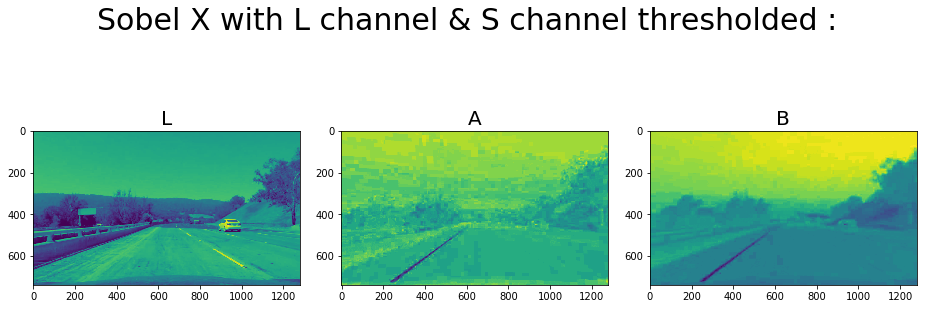

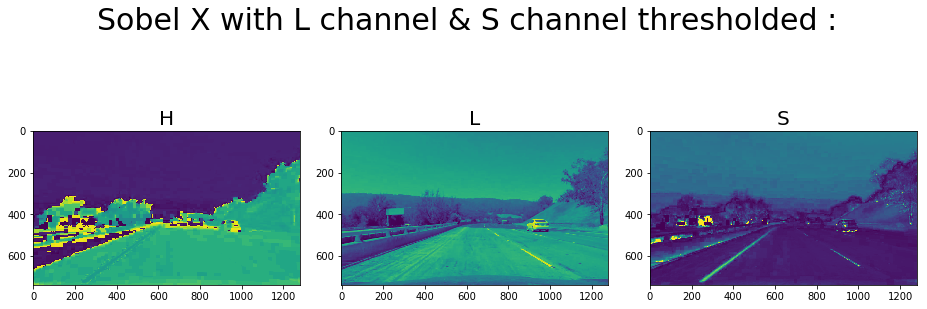

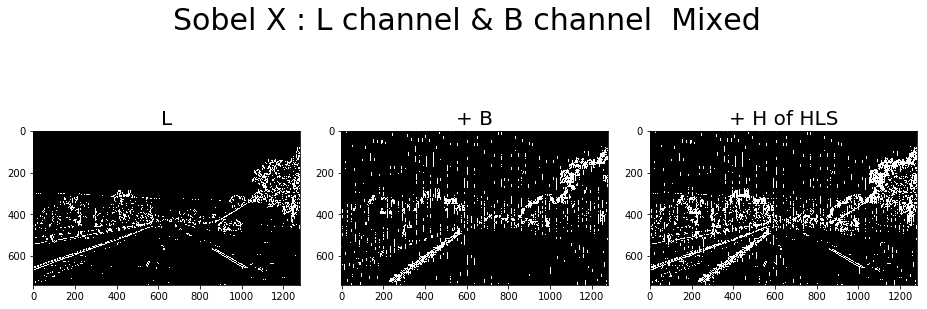

skip


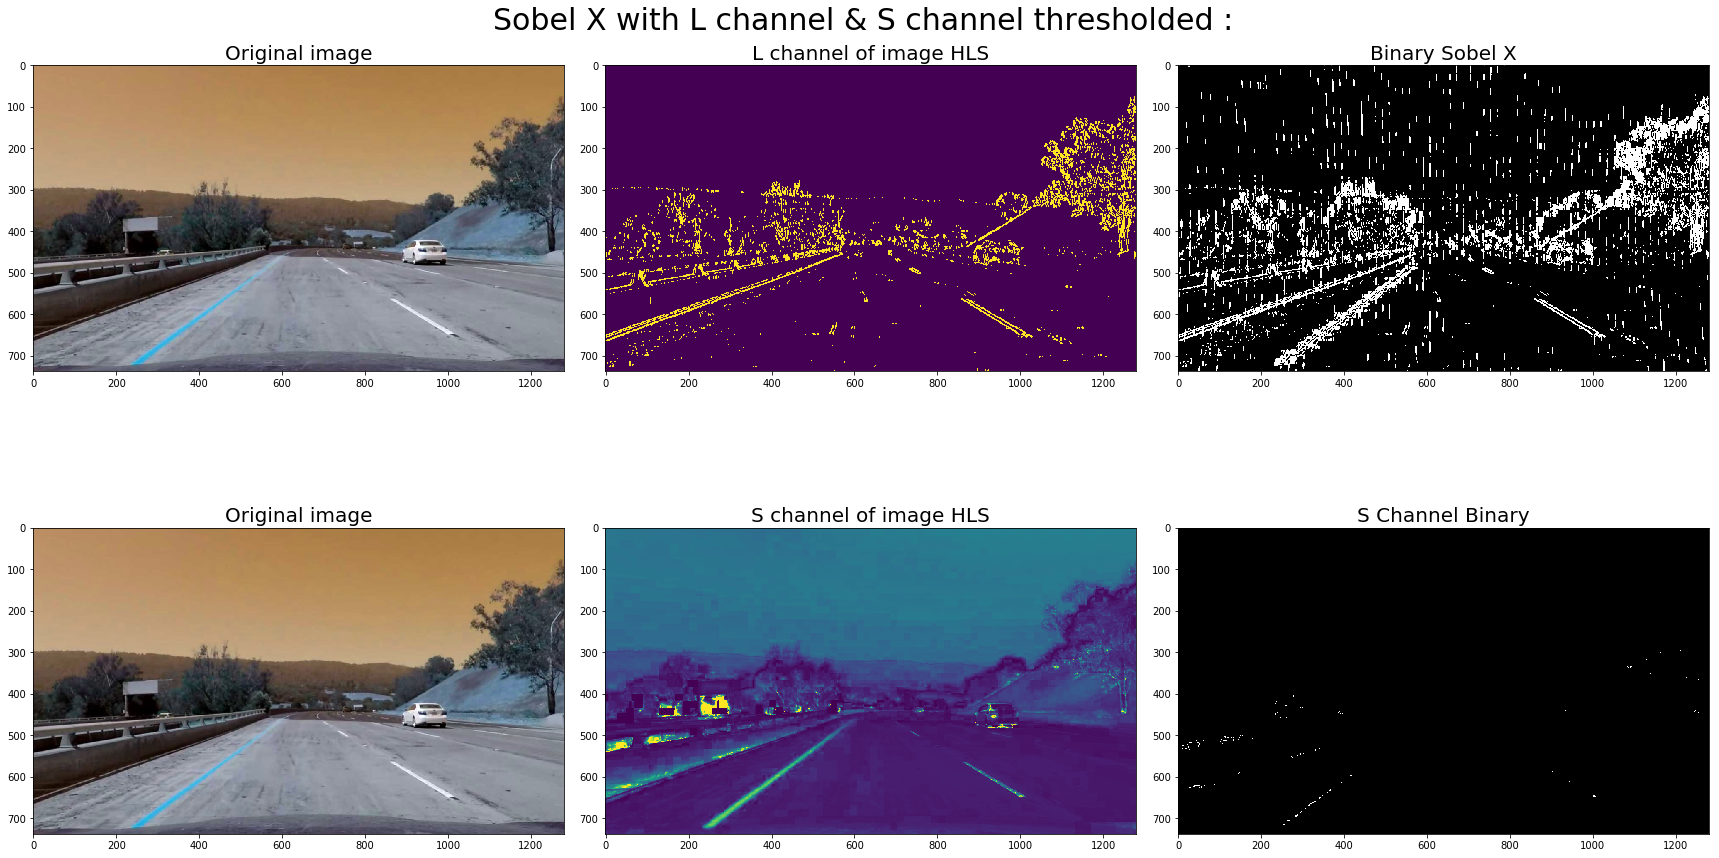

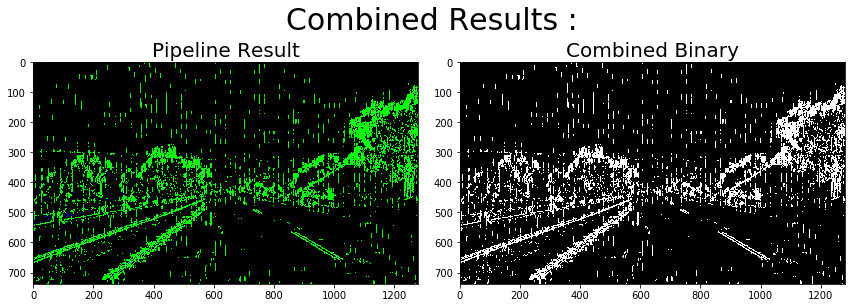

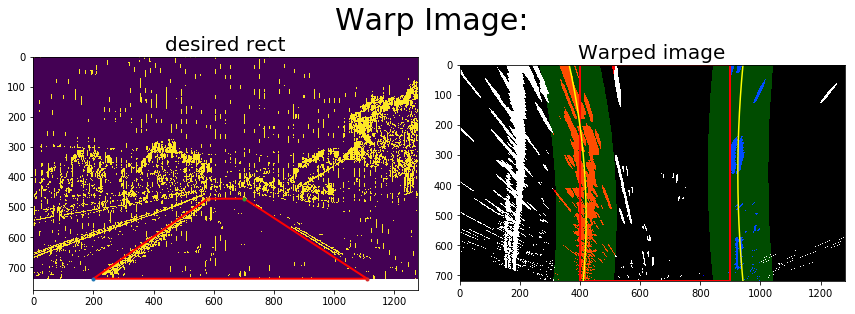

SANITY CHECK?
l_curv: 758.340098818 , r_curv: 1246.26260643
lane_width: 534.397882943


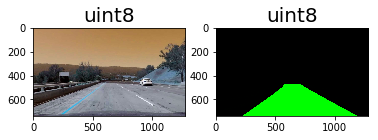

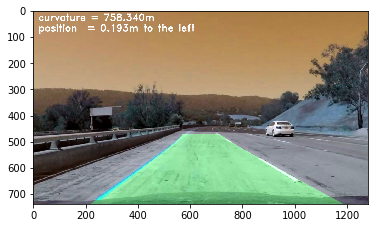

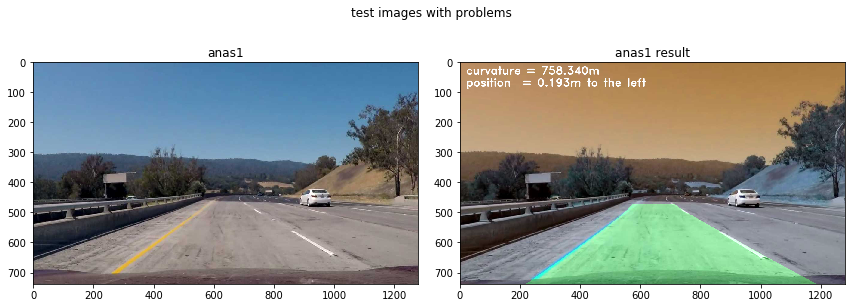

In [108]:
anas_image1 = cv2.imread('test_images/anas1.jpg')
anas_image1_reult = find_lane_main_pipeline(anas_image1, s_thresh=(200, 230), sobel_thresh=(20, 100), do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test images with problems")
ax1.imshow(cv2.cvtColor(anas_image1,cv2.COLOR_BGR2RGB))
ax1.set_title("anas1")
ax2.imshow(anas_image1_reult)
ax2.set_title("anas1 result")
plt.show()


### new issue , now we need santiy check
I'll check a sequance of 11 photos they make crazy curve

In [ ]:
#clear Line()
left_line.detected, right_line.detected = False, False

sanitycheck_01 = cv2.imread('test_images/sanitycheck_01.jpg')
sanitycheck_01_reult = find_lane_main_pipeline(sanitycheck_01, do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test images with problems")
ax1.imshow(cv2.cvtColor(sanitycheck_01,cv2.COLOR_BGR2RGB))
ax1.set_title("sanitycheck_01")
ax2.imshow(sanitycheck_01_reult)
ax2.set_title("sanitycheck_01 result")
plt.show()

In [ ]:
sanitycheck_02 = cv2.imread('test_images/sanitycheck_02.jpg')
sanitycheck_02_reult = find_lane_main_pipeline(sanitycheck_02, do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test images with problems")
ax1.imshow(cv2.cvtColor(sanitycheck_02,cv2.COLOR_BGR2RGB))
ax1.set_title("sanitycheck_02")
ax2.imshow(sanitycheck_02_reult)
ax2.set_title("sanitycheck_02 result")
plt.show()

In [ ]:
sanitycheck_03 = cv2.imread('test_images/sanitycheck_03.jpg')
sanitycheck_03_reult = find_lane_main_pipeline(sanitycheck_03, do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test images with problems")
ax1.imshow(cv2.cvtColor(sanitycheck_03,cv2.COLOR_BGR2RGB))
ax1.set_title("sanitycheck_03")
ax2.imshow(sanitycheck_03_reult)
ax2.set_title("sanitycheck_03 result")
plt.show()

In [ ]:
sanitycheck_04 = cv2.imread('test_images/sanitycheck_04.jpg')
sanitycheck_04_reult = find_lane_main_pipeline(sanitycheck_04, do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test images with problems")
ax1.imshow(cv2.cvtColor(sanitycheck_04,cv2.COLOR_BGR2RGB))
ax1.set_title("sanitycheck_04")
ax2.imshow(sanitycheck_04_reult)
ax2.set_title("sanitycheck_04 result")
plt.show()

In [ ]:
sanitycheck_05 = cv2.imread('test_images/sanitycheck_05.jpg')
sanitycheck_05_reult = find_lane_main_pipeline(sanitycheck_05, do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test images with problems")
ax1.imshow(cv2.cvtColor(sanitycheck_05,cv2.COLOR_BGR2RGB))
ax1.set_title("sanitycheck_05")
ax2.imshow(sanitycheck_05_reult)
ax2.set_title("sanitycheck_05 result")
plt.show()

In [ ]:
sanitycheck_06 = cv2.imread('test_images/sanitycheck_06.jpg')
sanitycheck_06_reult = find_lane_main_pipeline(sanitycheck_06, do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test images with problems")
ax1.imshow(cv2.cvtColor(sanitycheck_06,cv2.COLOR_BGR2RGB))
ax1.set_title("sanitycheck_06")
ax2.imshow(sanitycheck_06_reult)
ax2.set_title("sanitycheck_06 result")
plt.show()

In [ ]:
#clear Line()
#left_line.detected, right_line.detected = False, False

sanitycheck_07 = cv2.imread('test_images/sanitycheck_07.jpg')
sanitycheck_07_reult = find_lane_main_pipeline(sanitycheck_07, do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test images with problems")
ax1.imshow(cv2.cvtColor(sanitycheck_07,cv2.COLOR_BGR2RGB))
ax1.set_title("sanitycheck_07")
ax2.imshow(sanitycheck_07_reult)
ax2.set_title("sanitycheck_07 result")
plt.show()

In [ ]:
sanitycheck_08 = cv2.imread('test_images/sanitycheck_08.jpg')
sanitycheck_08_reult = find_lane_main_pipeline(sanitycheck_08, do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test images with problems")
ax1.imshow(cv2.cvtColor(sanitycheck_08,cv2.COLOR_BGR2RGB))
ax1.set_title("sanitycheck_08")
ax2.imshow(sanitycheck_08_reult)
ax2.set_title("sanitycheck_08 result")
plt.show()

In [ ]:
sanitycheck_09 = cv2.imread('test_images/sanitycheck_09.jpg')
sanitycheck_09_reult = find_lane_main_pipeline(sanitycheck_09, do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test images with problems")
ax1.imshow(cv2.cvtColor(sanitycheck_09,cv2.COLOR_BGR2RGB))
ax1.set_title("sanitycheck_09")
ax2.imshow(sanitycheck_09_reult)
ax2.set_title("sanitycheck_09 result")
plt.show()

In [ ]:
sanitycheck_10 = cv2.imread('test_images/sanitycheck_10.jpg')
sanitycheck_10_reult = find_lane_main_pipeline(sanitycheck_10, do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test images with problems")
ax1.imshow(cv2.cvtColor(sanitycheck_10,cv2.COLOR_BGR2RGB))
ax1.set_title("sanitycheck_10")
ax2.imshow(sanitycheck_10_reult)
ax2.set_title("sanitycheck_10 result")
plt.show()

In [ ]:
sanitycheck_11 = cv2.imread('test_images/sanitycheck_11.jpg')
sanitycheck_11_reult = find_lane_main_pipeline(sanitycheck_11, do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test images with problems")
ax1.imshow(cv2.cvtColor(sanitycheck_11,cv2.COLOR_BGR2RGB))
ax1.set_title("sanitycheck_11")
ax2.imshow(sanitycheck_11_reult)
ax2.set_title("sanitycheck_11 result")
plt.show()

### new issue, sanity check need to be stronger, at the frames below the lane is shifter to the left under shadow conditions

search


C:\D\Anas\mozakra\ML\CarND013\term1\CarND-Project4_Advanced-Lane-Lines\lanesearch.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)


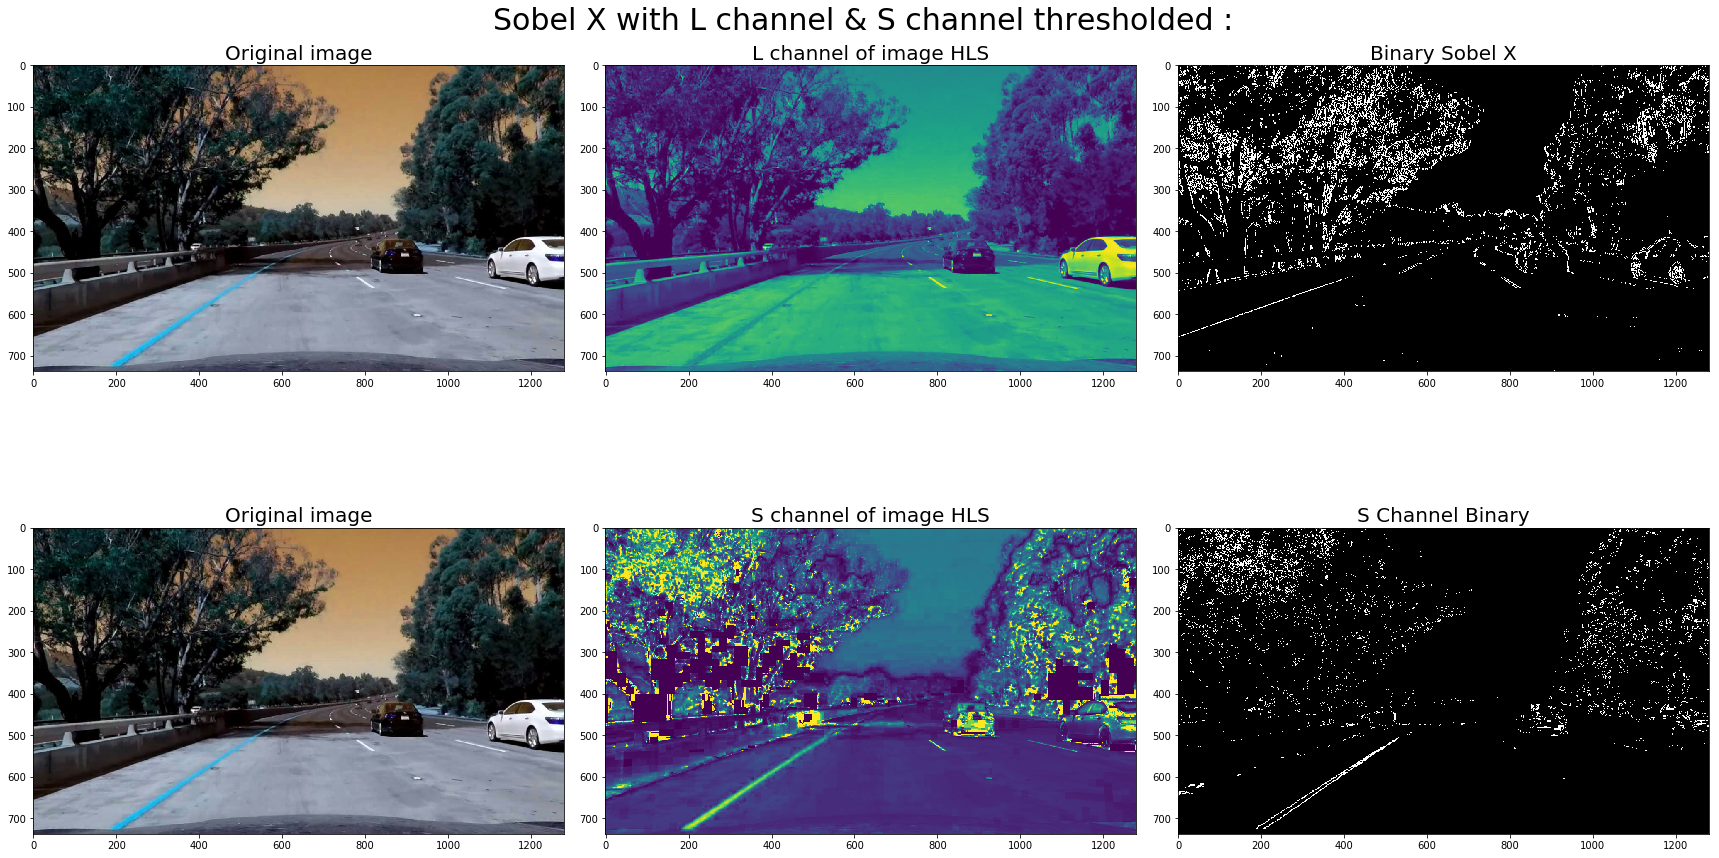

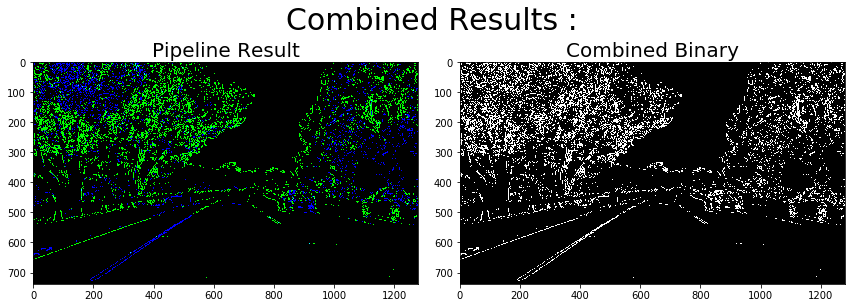

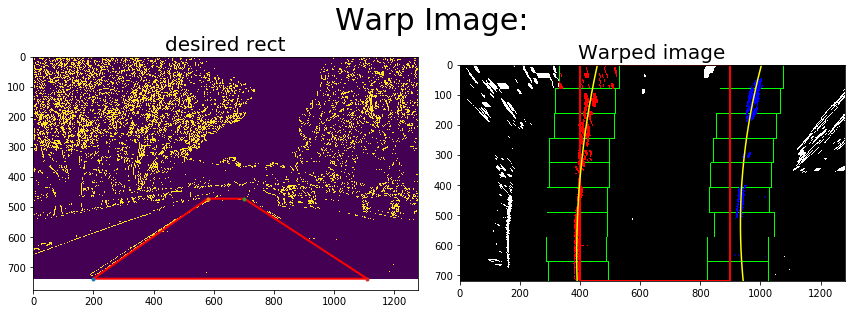

SANITY CHECK?
l_curv: 944.200895552 , r_curv: 656.634494755
lane_width: 553.261018835


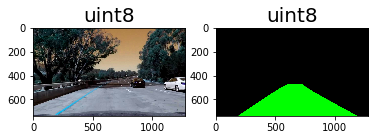

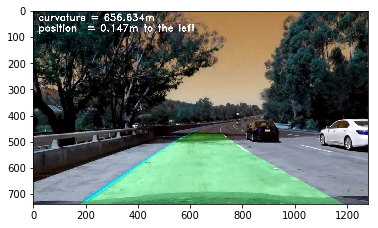

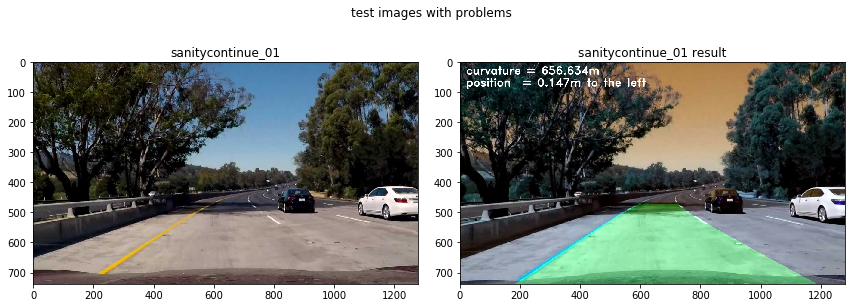

In [97]:
#clear Line()
left_line.detected, right_line.detected = False, False

sanitycontinue_01 = cv2.imread('test_images/sanitycontinue_01.jpg')
sanitycontinue_01_reult = find_lane_main_pipeline(sanitycontinue_01, s_thresh=(140, 190), sobel_thresh=(25, 100), do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test images with problems")
ax1.imshow(cv2.cvtColor(sanitycontinue_01,cv2.COLOR_BGR2RGB))
ax1.set_title("sanitycontinue_01")
ax2.imshow(sanitycontinue_01_reult)
ax2.set_title("sanitycontinue_01 result")
plt.show()

In [ ]:
sanitycontinue_02 = cv2.imread('test_images/sanitycontinue_02.jpg')
sanitycontinue_02_reult = find_lane_main_pipeline(sanitycontinue_02, do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test images with problems")
ax1.imshow(cv2.cvtColor(sanitycontinue_02,cv2.COLOR_BGR2RGB))
ax1.set_title("sanitycontinue_02")
ax2.imshow(sanitycontinue_02_reult)
ax2.set_title("sanitycontinue_02 result")
plt.show()

In [ ]:
sanitycontinue_03 = cv2.imread('test_images/sanitycontinue_03.jpg')
sanitycontinue_03_reult = find_lane_main_pipeline(sanitycontinue_03, do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test images with problems")
ax1.imshow(cv2.cvtColor(sanitycontinue_03,cv2.COLOR_BGR2RGB))
ax1.set_title("sanitycontinue_03")
ax2.imshow(sanitycontinue_03_reult)
ax2.set_title("sanitycontinue_03 result")
plt.show()

In [ ]:
sanitycontinue_04 = cv2.imread('test_images/sanitycontinue_04.jpg')
sanitycontinue_04_reult = find_lane_main_pipeline(sanitycontinue_04, do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test images with problems")
ax1.imshow(cv2.cvtColor(sanitycontinue_04,cv2.COLOR_BGR2RGB))
ax1.set_title("sanitycontinue_04")
ax2.imshow(sanitycontinue_04_reult)
ax2.set_title("sanitycontinue_04 result")
plt.show()

In [ ]:
sanitycontinue_05 = cv2.imread('test_images/sanitycontinue_05.jpg')
sanitycontinue_05_reult = find_lane_main_pipeline(sanitycontinue_05, do_plot=True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test images with problems")
ax1.imshow(cv2.cvtColor(sanitycontinue_05,cv2.COLOR_BGR2RGB))
ax1.set_title("sanitycontinue_05")
ax2.imshow(sanitycontinue_05_reult)
ax2.set_title("sanitycontinue_05 result")
plt.show()